In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# leer las trayectorias generadas
import h5py

data_file = "trayectorias.h5"

with h5py.File(data_file, "r") as hf:
    trayectorias = hf["trayectorias"][:]

# Asegúrate de que las trayectorias se ajusten a tus necesidades específicas
# Si es necesario, puedes transformar los datos en tensores TensorFlow
trayectorias = tf.constant(trayectorias, dtype=tf.float32)
trayectorias

<tf.Tensor: shape=(300, 2, 300), dtype=float32, numpy=
array([[[-2.904083  , -3.1910958 , -3.3053868 , ..., -1.941522  ,
         -1.9957964 , -2.0079956 ],
        [-2.9946606 , -1.395541  , -0.40961367, ..., -0.5810437 ,
         -0.23911496,  0.04743894]],

       [[ 1.0341662 ,  0.5528964 ,  0.04001783, ..., -1.6514131 ,
         -1.81554   , -1.9262949 ],
        [-3.5136    , -3.7044296 , -3.972271  , ..., -1.4240484 ,
         -1.0259275 , -0.6332938 ]],

       [[-4.7879586 , -4.531147  , -4.4170957 , ...,  1.0578188 ,
          0.86573315,  0.65481085],
        [ 3.18801   ,  1.1492605 ,  0.66270065, ..., -1.3686956 ,
         -1.5045241 , -1.650535  ]],

       ...,

       [[-0.0367098 , -0.19831902, -0.36693868, ..., -1.9724144 ,
         -1.9131918 , -1.8322136 ],
        [-1.1743339 , -1.2382736 , -1.2778753 , ...,  0.35090762,
          0.5287188 ,  0.6779482 ]],

       [[ 4.4277787 ,  4.4203725 ,  4.37283   , ..., -0.9883631 ,
         -0.7899939 , -0.57232434],
      

In [3]:
# n_particula, (posicion,velocidad), tiempo
trayectorias.shape
#TensorShape([300,2,300])

TensorShape([300, 2, 300])

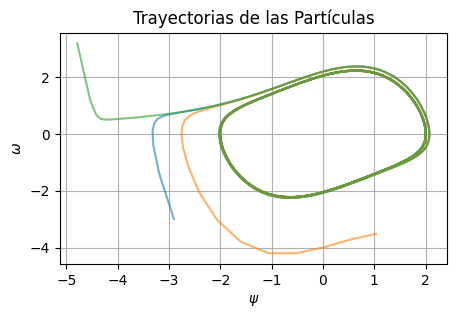

In [4]:
def plot_trayectoria(trayectorias, N):
    plt.figure(figsize=(5, 3))
    if len(trayectorias.shape) == 2:
        print('one data point')
        plt.plot(trayectorias[0], trayectorias[1], alpha=0.6)

    else:
        for i in range(N):
            plt.plot(trayectorias[i][0], trayectorias[i][1], alpha=0.6)
    plt.xlabel(r'$\psi$')
    plt.ylabel(r'$\omega$')
    plt.title('Trayectorias de las Partículas')
    plt.grid()
    plt.show()

plot_trayectoria(trayectorias, 3)

In [5]:
trayectorias

<tf.Tensor: shape=(300, 2, 300), dtype=float32, numpy=
array([[[-2.904083  , -3.1910958 , -3.3053868 , ..., -1.941522  ,
         -1.9957964 , -2.0079956 ],
        [-2.9946606 , -1.395541  , -0.40961367, ..., -0.5810437 ,
         -0.23911496,  0.04743894]],

       [[ 1.0341662 ,  0.5528964 ,  0.04001783, ..., -1.6514131 ,
         -1.81554   , -1.9262949 ],
        [-3.5136    , -3.7044296 , -3.972271  , ..., -1.4240484 ,
         -1.0259275 , -0.6332938 ]],

       [[-4.7879586 , -4.531147  , -4.4170957 , ...,  1.0578188 ,
          0.86573315,  0.65481085],
        [ 3.18801   ,  1.1492605 ,  0.66270065, ..., -1.3686956 ,
         -1.5045241 , -1.650535  ]],

       ...,

       [[-0.0367098 , -0.19831902, -0.36693868, ..., -1.9724144 ,
         -1.9131918 , -1.8322136 ],
        [-1.1743339 , -1.2382736 , -1.2778753 , ...,  0.35090762,
          0.5287188 ,  0.6779482 ]],

       [[ 4.4277787 ,  4.4203725 ,  4.37283   , ..., -0.9883631 ,
         -0.7899939 , -0.57232434],
      

# ordenamiento de los datos

In [6]:
# shape: TensorShape([300, 2, 300])
dataset = tf.data.Dataset.from_tensor_slices(trayectorias)

# Determina los tamaños de tus conjuntos de datos
size = tf.data.experimental.cardinality(dataset).numpy()
print("Total de datos: ", size)
train_size = int(0.7 * size)
val_size = int(0.15 * size)
test_size = int(0.15 * size)

# Mezcla tus datos
dataset = dataset.shuffle(size)

# Divide tus datos en conjuntos de entrenamiento, validación y prueba
train_data = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_data = remaining.take(val_size)
test_data = remaining.skip(val_size)

print('\ttraining size: ', len(train_data))
print('\tvalidation size: ', len(val_data))
print('\ttesting size: ', len(test_data))

# Para obtener el primer elemento
# first_data = next(iter(dataset.take(1)))
# second_data = next(iter(dataset.skip(1).take(1)))

# print("Forma de un solo dato: ", first_data.shape)

# Convertir train_data a un tensor
train_data_tensor = tf.concat(list(train_data), axis=0)

# Imprimir la forma del tensor de entrenamiento
print("Forma del tensor de entrenamiento: ", train_data_tensor.shape)

# Imprimir el tensor de entrenamiento
print("Tensor de entrenamiento: ")
print(train_data_tensor)


Total de datos:  300
	training size:  210
	validation size:  45
	testing size:  45
Forma del tensor de entrenamiento:  (420, 300)
Tensor de entrenamiento: 
tf.Tensor(
[[-0.83199793 -1.0566298  -1.2607316  ... -1.6943945  -1.5730947
  -1.436132  ]
 [-1.7298732  -1.6148565  -1.4236889  ...  0.84599286  0.96572095
   1.0820816 ]
 [-1.956792   -1.6018394  -1.2557172  ...  1.1216903   1.3859931
   1.6103874 ]
 ...
 [-4.2523255  -4.374912   -4.1395187  ... -0.38805777 -0.07625746
   0.1802992 ]
 [-1.6383574  -1.2883759  -0.9317118  ...  1.4446391   1.6578233
   1.8200418 ]
 [ 2.6309018   2.624433    2.728472   ...  1.7674052   1.4103321
   1.0123633 ]], shape=(420, 300), dtype=float32)


forma altermativa de ordenar los datos, tener los inputs y outputs separados,
de manera de utilizar:

```
model.fit(
    X_train, Y_train, validation_data=(X_valid, Y_valid) 
         )
```

Forma del conjunto de entrenamiento:  (210, 2, 300)
Forma del conjunto de validación:  (45, 2, 300)
Forma del conjunto de prueba:  (45, 2, 300)
Forma de X_train:  (210, 300)
Forma de P_train:  (210, 300)


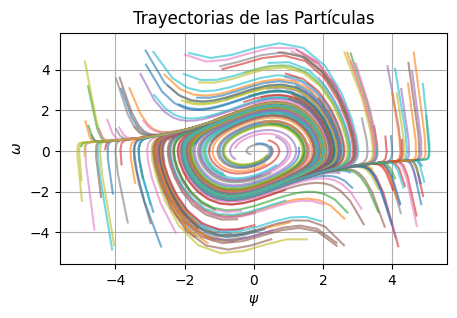

In [7]:
# Separar en train, valid, test
train_data = trayectorias[:210, :, :]
val_data = trayectorias[210:255, :, :]
test_data = trayectorias[255:, :, :]

# Imprimir las formas de los conjuntos de datos
print("Forma del conjunto de entrenamiento: ", train_data.shape)
print("Forma del conjunto de validación: ", val_data.shape)
print("Forma del conjunto de prueba: ", test_data.shape)

# Obtener tensores X_train, P_train, X_valid, P_valid
X_train = train_data[:, 0, :]
P_train = train_data[:, 1, :]
X_valid = val_data[:, 0, :]
P_valid = val_data[:, 1, :]
X_test = test_data[:, 0, :]
P_test = test_data[:, 1, :]

# Imprimir las formas de los tensores
print("Forma de X_train: ", X_train.shape)
print("Forma de P_train: ", P_train.shape)

plot_trayectoria(train_data, 210)

# El modelo

Debido a que este modelo utiliza condiciones iniciales y no las toma como input, significa que el modelo habrá de aprender estas condiciones iniciales,
por tanto solo puede aprender de una curva a la vez


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, metrics

class VanderPolModel(tf.keras.Model):
    """Modelo de vanderPol, toma la input de tiempo"""
    def __init__(self, activation="tanh",**kwargs):
        super().__init__(**kwargs)

        self.hidden1 = layers.Dense(64, activation=activation)
        self.hidden2 = layers.Dense(64, activation=activation)
        self.hidden3 = layers.Dense(64, activation=activation)
        self.hidden4 = layers.Dense(64, activation=activation)
        self.position = layers.Dense(1, activation=activation)

    def call(self, inputs):
        inputs_expanded = tf.expand_dims(inputs, axis=-1) 
        z = self.hidden1(inputs_expanded)
        z = self.hidden2(z)
        z = self.hidden3(z)
        z = self.hidden4(z)
        x = self.position(z)
        return x

In [9]:
t = tf.range(300, dtype=tf.float32)

In [10]:
@tf.function
def physics_loss(y_true, y_pred, model, inputs, X_target, P_target, params):
    mu = params.get('mu', 2.0)
    position_weight = params.get('position_weight', 10)
    momentum_weight = params.get('momentum_weight', 5)
    data_weight = params.get('data_weight', 1)
    phys_weight = params.get('phys_weight', 1)

    inputs = tf.expand_dims(inputs, axis=-1)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(inputs)
        X_predicted = model(inputs)
        dx_dt = tape.gradient(X_predicted, inputs)
        d2x_dt2 = tape.gradient(dx_dt, inputs)

    f = d2x_dt2 - mu * (1 - tf.square(X_predicted)) * dx_dt + X_predicted
    
    # Physics loss
    position_loss = tf.reduce_mean(tf.square(X_target[0] - X_predicted[0]))
    momentum_loss = tf.reduce_mean(tf.square(P_target[0] - dx_dt[0]))
    
    loss = phys_weight * tf.reduce_mean(tf.square(f))
    loss += position_weight * position_loss
    loss += momentum_weight * momentum_loss
    
    # Data loss (optional, depending on your needs)
    # data_loss = data_weight * tf.reduce_mean(tf.square(y_true - y_pred))
    # loss += data_loss
    
    return loss


In [11]:
def train(model, inputs, targets, params, optimizer, epochs=100, batch_size=32):
    # Compile the model with the partial physics loss function
    X_target = targets[0]
    P_target = targets[1]

    partial_physics_loss = functools.partial(physics_loss, model=model, 
        X_target=X_target, P_target=P_target, params=params)
    model.compile(optimizer=optimizer, loss=partial_physics_loss)

    # Train the model
    history = model.fit(inputs, X_target, epochs=epochs, batch_size=batch_size)

    return history


In [17]:
params = {'mu': 2.0, 'position_weight': 10, 'momentum_weight': 5, 'phys_weight': 1}
model = VanderPolModel()
inputs = t
history = train(model, inputs, [X_train[0], P_train[0]], params, optimizer)


NameError: name 'optimizer' is not defined

In [ ]:
# Compilar el modelo con la función de pérdida parcial
model.compile(optimizer=optimizer, loss=partial_physics_loss)

# Entrenar el modelo
history = model.fit(inputs, [X_train[0], P_train[0]], epochs=100, batch_size=32)


ValueError: Data cardinality is ambiguous:
  x sizes: 210
  y sizes: 300, 300
Make sure all arrays contain the same number of samples.

In [ ]:
physics_loss_metric = metrics.Mean('physics_loss', dtype=tf.float32)
position_loss_metric = metrics.Mean('position_loss', dtype=tf.float32)
momentum_loss_metric = metrics.Mean('momentum_loss', dtype=tf.float32)


def physics_loss(X_target, P_target, X_predicted, dx_dt, mu=2.0, position_weight=10, momentum_weight=5):
    # Calcular las pérdidas individuales
    physics_loss = tf.reduce_mean(tf.square(X_target[0] - X_predicted[0]))
    position_loss = tf.reduce_mean(tf.square(X_target[0] - X_predicted[0]))
    momentum_loss = tf.reduce_mean(tf.square(P_target[0] - dx_dt[0]))

    physics_loss_metric.update_state(physics_loss)
    position_loss_metric.update_state(position_loss)
    momentum_loss_metric.update_state(momentum_loss)

    # Devuelve la suma ponderada de las pérdidas
    return physics_loss + position_weight * position_loss + momentum_weight * momentum_loss

# Crear función parcial con los argumentos específicos
partial_physics_loss = functools.partial(physics_loss, X_train, P_train)

# Compilar el modelo con la función de pérdida parcial
model.compile(optimizer=optimizer, loss=partial_physics_loss)

# Entrenar el modelo
history = model.fit(inputs, [X_train[0], P_train[0]], epochs=100, batch_size=32)


Epoch 1/100


10/10 [==============================] - 1s 3ms/step - loss: 63.9855
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 56.6985
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 57.2345
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 61.7208
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 64.8783
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 61.3873
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 64.7971
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 54.5982
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 60.8164
Epoch 10/100
10/10 [==============================] - 0s 3ms/step - loss: 60.7016
Epoch 11/100
10/10 [==============================] - 0s 4ms/step - loss: 62.8993
Epoch 12/100
10/10 [==============================] - 0s 3ms/step - loss: 54.4606
Epoch 13/100
10/10 [=================

In [ ]:
# Compilar el modelo con múltiples funciones de pérdida
model = VanderPolModel()
inputs = t

import functools
# Crear función parcial con los argumentos específicos
partial_physics_loss = functools.partial(physics_loss, X_train, P_train)

optimizer = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=partial_physics_loss, 
    metrics=[physics_loss_metric, position_loss_metric,momentum_loss_metric])


# Entrenar el modelo con tus datos (asegúrate de tener X_train y P_train preparados)
history = model.fit(inputs, [X_train[0], P_train[0]], epochs=100, batch_size=32)



Epoch 1/100


TypeError: in user code:

    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1131, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1225, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)

    TypeError: update_state() got multiple values for argument 'sample_weight'


In [ ]:
print(history.history.keys())

dict_keys(['loss'])


In [ ]:
import pandas as pd

pd.DataFrame(history.history)

,loss
0,2.403802
1,2.210636
2,2.093657
3,2.068455
4,2.088016
...,...
95,1.740423
96,1.719420
97,1.733396
98,1.738017


# Modelo Multi Curva
El desarrollo original, pero el problema de 1 input lo hace inviable

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers

class VanderPolModel(tf.keras.Model):
    """Modelo de vanderPol, toma la input de tiempo"""
    def __init__(self, activation="tanh",**kwargs):
        super().__init__(**kwargs)
        self.hidden1 = layers.Dense(64, activation=activation)
        self.hidden2 = layers.Dense(64, activation=activation)
        self.hidden3 = layers.Dense(64, activation=activation)
        self.hidden4 = layers.Dense(64, activation=activation)
        self.position = layers.Dense(1, activation=activation)

    def call(self, inputs):
        z = self.hidden1(inputs)
        z = self.hidden2(z)
        z = self.hidden3(z)
        z = self.hidden4(z)
        x = self.position(z)
        return x

In [ ]:
# La entrada es fija
t = tf.range(300, dtype=tf.float32)
# Copiar el tensor horizontalmente
t_matrix = tf.tile(tf.expand_dims(t, axis=0), [300, 1])

# Ver la forma del tensor resultante
print(t_matrix)

tf.Tensor(
[[  0.   1.   2. ... 297. 298. 299.]
 [  0.   1.   2. ... 297. 298. 299.]
 [  0.   1.   2. ... 297. 298. 299.]
 ...
 [  0.   1.   2. ... 297. 298. 299.]
 [  0.   1.   2. ... 297. 298. 299.]
 [  0.   1.   2. ... 297. 298. 299.]], shape=(300, 300), dtype=float32)


$$
\frac{d^2 x}{dt^2} - \mu(1-x^2) \frac{dx}{dt} +x = 0
$$

In [ ]:
def physics_loss(model, inputs, X_target, P_target, mu=2.0, position_weight=10, momentum_weight=5):
    inputs= tf.expand_dims(inputs, axis=-1)  # Expandir dimensiones

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(inputs)
        X_predicted = model(inputs)
        dx_dt = tape.gradient(X_predicted, inputs)
        d2x_dt2 = tape.gradient(dx_dt, inputs)

    f = d2x_dt2 - mu * (1 - tf.square(X_predicted)) * dx_dt + X_predicted

    # Calcular la pérdida
    loss = tf.reduce_mean(tf.square(f))
    loss += position_weight*tf.reduce_mean(tf.square(X_target[:,0] - X_predicted[:,0]))
    loss += momentum_weight*tf.reduce_mean(tf.square(P_target[:,0] - dx_dt[:,0]))

    return loss


model = VanderPolModel()
inputs = t_matrix[:210]
loss = physics_loss(model, inputs, X_train, P_test)

print("Perdida Escalar:", loss)

InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [210,300,1,1] vs. [210,300,1] [Op:Mul] name: 

In [ ]:
# Definir el modelo y el optimizador
model = VanderPolModel()
optimizer = optimizers.Adam(learning_rate=0.001)

# Número de épocas y tamaño del lote
epochs = 100
batch_size = 32

# Bucle de entrenamiento
for epoch in range(epochs):
    # Mezclar y dividir los datos en lotes
    indices = tf.range(210)  # Asegúrate de tener el rango correcto
    tf.random.shuffle(indices)
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i : i + batch_size]
        inputs_batch = tf.gather(inputs, batch_indices)
        X_train_batch = tf.gather(X_train, batch_indices)
        P_train_batch = tf.gather(P_train, batch_indices)

        # Calcular la pérdida y los gradientes
        with tf.GradientTape() as tape:
            loss = physics_loss(model, inputs_batch, X_train_batch, P_train_batch)
        gradients = tape.gradient(loss, model.trainable_variables)

        # Aplicar los gradientes usando el optimizador
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Imprimir la pérdida al final de cada época
    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.numpy()}")

# Verificar la pérdida final
final_loss = physics_loss(model, inputs, X_train, P_train)
print("Pérdida final:", final_loss.numpy())


Época 10/100, Pérdida: 154.32281494140625
Época 20/100, Pérdida: 154.3328857421875
Época 30/100, Pérdida: 154.33267211914062


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.tanh, input_shape=(1,)),  # Input layer (time)
    tf.keras.layers.Dense(64, activation=tf.nn.tanh),
    tf.keras.layers.Dense(64, activation=tf.nn.tanh),
    tf.keras.layers.Dense(64, activation=tf.nn.tanh),
    tf.keras.layers.Dense(1) # output position
])

def initial_value_loss(y_true, y_pred):
    # Condición de borde
    return tf.square(y_true[0] - y_pred[0])

def point_loss(y_true, y_pred):
    # Loss function for every point
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Compile the model
model.compile(optimizer='adam', loss=[initial_value_loss, point_loss])

In [ ]:
x_pred = next(iter(train_data.take(1)))[0,:]
v_pred = next(iter(train_data.take(1)))[1,:]

In [ ]:
x_pred.shape

TensorShape([300])

In [ ]:
# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=100)

# un optimizador

In [16]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras_tuner import RandomSearch

# Supongamos que tus datos están en el tensor 'trayectorias'
trayectorias

# Separa tus datos en conjuntos de entrenamiento, validación y prueba
train_data, test_data = train_test_split(trayectorias, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

def build_model(hp):
    # aqui va la construccion del modelo
    model = tf.keras.models.Sequential()
    
    # Añade tus capas aquí. Por ejemplo:
    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(tf.keras.layers.Dense(1))  # una sola salida para predecir la posición

    # Ajusta los hiperparámetros del optimizador Adam
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_beta_1 = hp.Float('beta_1', min_value=0.85, max_value=0.95, step=0.01)
    hp_beta_2 = hp.Float('beta_2', min_value=0.98, max_value=0.999, step=0.001)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate, beta_1=hp_beta_1, beta_2=hp_beta_2),
                loss=tf.keras.losses.MeanSquaredError(),  # usa MSE para la regresión
                metrics=['mse'])

    return model

tuner = RandomSearch(
    build_model,
    objective='mse',  # minimiza el error cuadrático medio
    max_trials=5,
    executions_per_trial=3)

tuner.search(train_data, epochs=60, validation_data=val_data)

# Obtén los hiperparámetros óptimos
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"La tasa de aprendizaje óptima para el optimizador es {best_hps.get('learning_rate')}.")
print(f"El beta_1 óptimo para el optimizador es {best_hps.get('beta_1')}.")
print(f"El beta_2 óptimo para el optimizador es {best_hps.get('beta_2')}.")


ModuleNotFoundError: No module named 'sklearn'